## Upload two ZIP files:


In [1]:
  from google.colab import files
  uploaded = files.upload()


Saving 377 images for Brian Tumor MRI Images.zip to 377 images for Brian Tumor MRI Images.zip


# Extract them to separate folders

In [2]:
import zipfile

for filename in uploaded.keys():
    foldername = filename.split('.')[0].replace(' ', '_').lower() + "_dataset"
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(foldername)
    print(f"✅ Extracted {filename} to {foldername}")

✅ Extracted 377 images for Brian Tumor MRI Images.zip to 377_images_for_brian_tumor_mri_images_dataset


#Inspect extracted folders

In [3]:
import os

# Automatically list all *_dataset folders
dataset_folders = [d for d in os.listdir() if d.endswith('_dataset') and os.path.isdir(d)]

for folder in dataset_folders:
    print(f"\n📁 Inspecting: {folder}")
    for root, dirs, files in os.walk(folder):
        print("📂", root)
        for file in files[:5]:
            print("   └──", file)



📁 Inspecting: 377_images_for_brian_tumor_mri_images_dataset
📂 377_images_for_brian_tumor_mri_images_dataset
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/No_Tumor
   └── N_48.jpg
   └── N_46_HF_.jpg
   └── N_46_SP_.jpg
   └── N_48_HF_.jpg
   └── N_47_DA_.jpg
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/Meningioma
   └── M_882_HF_.jpg
   └── M_881_SP_.jpg
   └── M_881_BR_.jpg
   └── M_881_DA_.jpg
   └── M_881_HF_.jpg
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/Glioma
   └── G_801_BR_.jpg
   └── G_800_RO_.jpg
   └── G_800_SP_.jpg
   └── G_800.jpg
   └── G_806_RO_.jpg
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/Pituit

#Load & Preprocess Dataset

In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Define image size (Swin-tiny default is 224x224)
IMG_SIZE = 224
BATCH_SIZE = 16

# Define transforms (you can later add augmentations here)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale MRI
])

# Paths
train_dir = '377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Training'
test_dir = '377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing'

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class mapping
class_names = train_dataset.classes
print("✅ Classes:", class_names)


✅ Classes: ['Glioma', 'Meningioma', 'No_Tumor', 'Pituitary']


#Visualize Sample Images

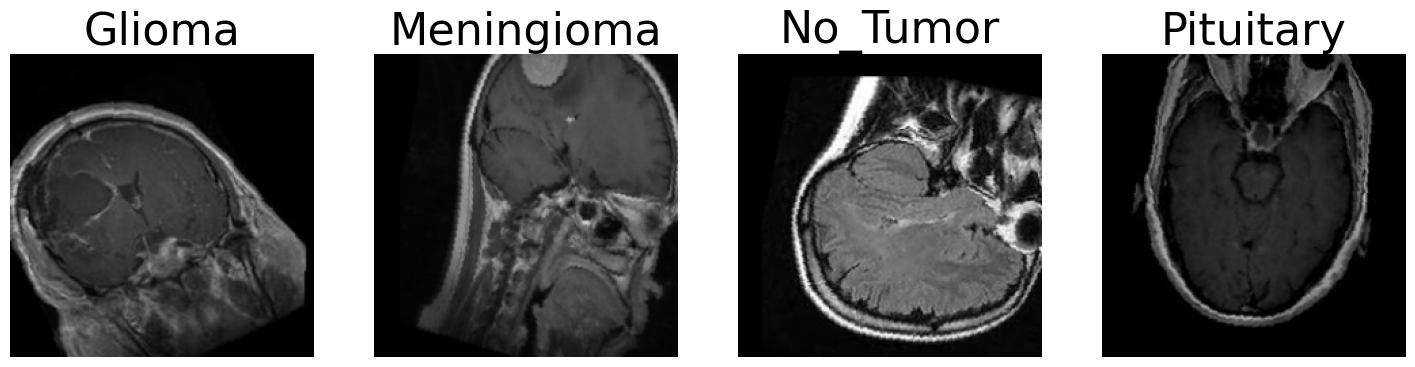

In [18]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title, fontsize=32)  # Increased font size to 32
    plt.axis('off')

# Find one image per class
examples = {}
for img, label in train_dataset:
    if label not in examples:
        examples[label] = img
    if len(examples) == len(class_names):
        break

# Prepare images and titles sorted by label index
imgs = [examples[i] for i in range(len(class_names))]
titles = [class_names[i] for i in range(len(class_names))]

# Show images in one grid
plt.figure(figsize=(18, 4))
for i in range(len(class_names)):
    plt.subplot(1, len(class_names), i + 1)
    imshow(imgs[i], titles[i])
plt.show()


# Image Augmentaiton

In [12]:
from torchvision import transforms

IMG_SIZE = 224

# Data augmentation transform (for training only)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=15),             # Rotation
    transforms.RandomHorizontalFlip(p=0.5),            # Horizontal Flip
    transforms.RandomVerticalFlip(p=0.2),              # Vertical Flip
    transforms.RandomAffine(degrees=0,                 # No rotation here, just translation
                            translate=(0.1, 0.1)),     # Horizontal and Vertical shift
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),  # Zoom In
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation on test set (only resizing and normalization)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [13]:
# Reload datasets with augmentation for training
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


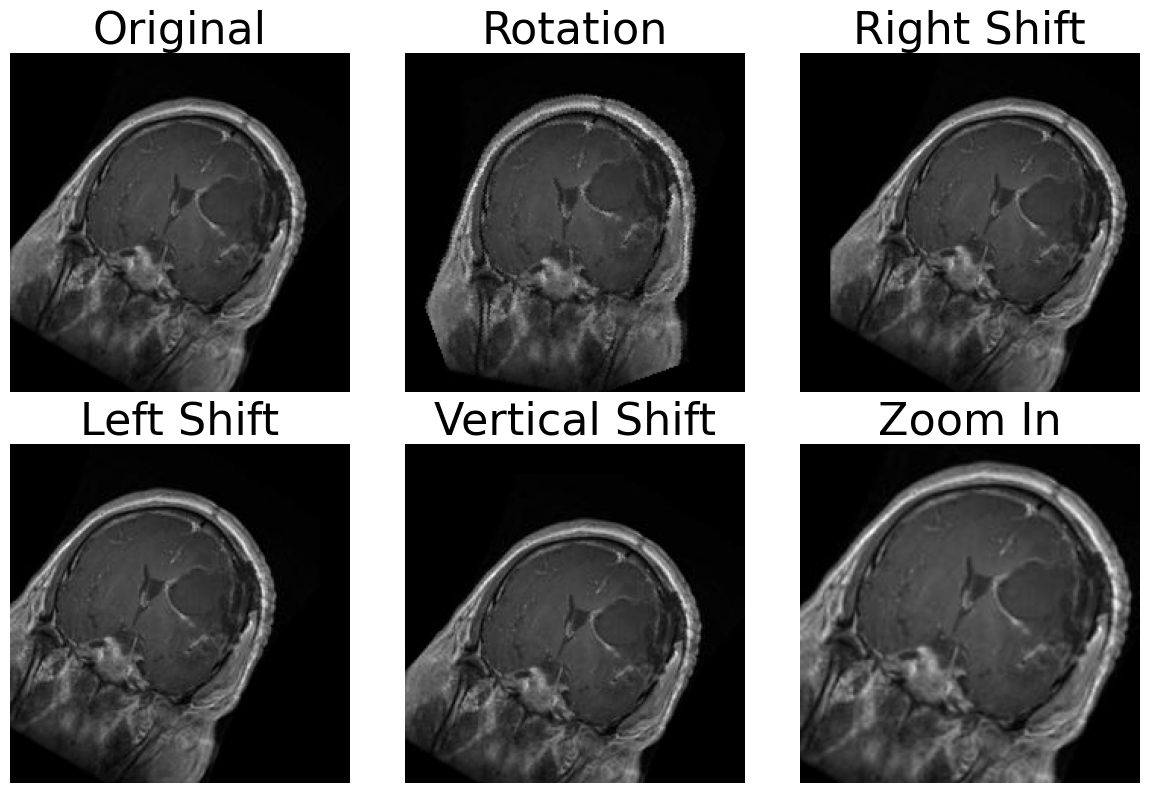

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
from PIL import Image

# Get one image from the dataset (PIL version for manual transform)
img_path, label = train_dataset.samples[0]
original_img = Image.open(img_path).convert("L")  # Convert to grayscale if needed

# Apply specific augmentations manually
rotated_img = TF.rotate(original_img, angle=20)
right_shift_img = TF.affine(original_img, angle=0, translate=(20, 0), scale=1, shear=0)
left_shift_img = TF.affine(original_img, angle=0, translate=(-20, 0), scale=1, shear=0)
vertical_shift_img = TF.affine(original_img, angle=0, translate=(0, 20), scale=1, shear=0)
zoom_in_img = TF.resized_crop(original_img, top=20, left=20, height=180, width=180, size=(224, 224))

# List of images and their titles
images = [original_img, rotated_img, right_shift_img, left_shift_img, vertical_shift_img, zoom_in_img]
titles = ["Original", "Rotation", "Right Shift", "Left Shift", "Vertical Shift", "Zoom In"]

# Plotting in 2x3 grid
plt.figure(figsize=(12, 8))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title, fontsize=32)  # Increased font size to 32
    plt.axis('off')
plt.tight_layout()
plt.show()


# Resize the Image

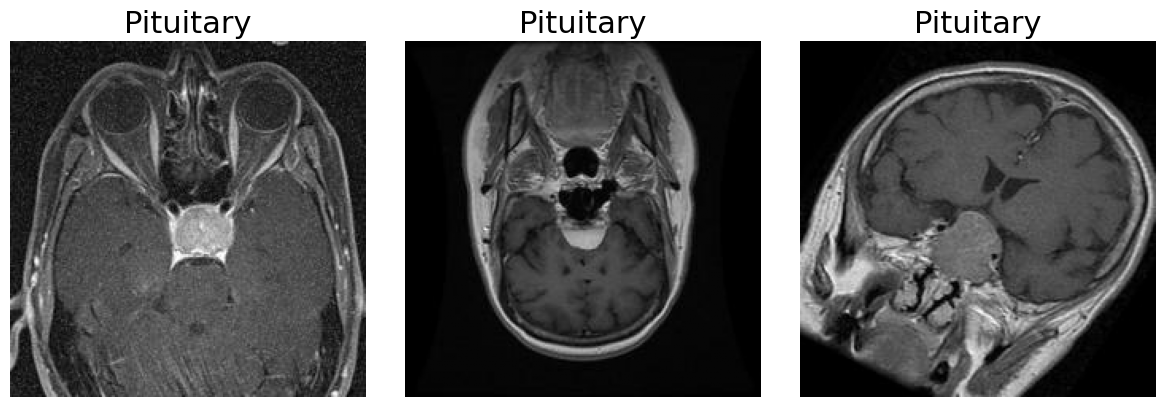

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Set image path (adjust class/folder as needed)
pituitary_dir = os.path.join(train_dir, 'Pituitary')
image_files = [os.path.join(pituitary_dir, f) for f in os.listdir(pituitary_dir) if f.endswith('.jpg')]

# Resize transform
resize_transform = transforms.Resize((224, 224))

# Load and resize 3 sample images
sample_imgs = []
for img_path in image_files[:3]:
    img = Image.open(img_path).convert("L")
    img_resized = resize_transform(img)
    sample_imgs.append(img_resized)

# Show resized images
plt.figure(figsize=(12, 4))
for i, img in enumerate(sample_imgs):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Pituitary", fontsize=22)  # Increased font size more
    plt.axis('off')
plt.tight_layout()
plt.show()
